# Identifying Entities in Healthcare Data

In [79]:
!pip install pycrf
!pip install sklearn-crfsuite

In [80]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter
import re
import pandas as pd

model = spacy.load("en_core_web_sm")

#### Download Train and Test Data

In [81]:
!wget https://cdn.upgrad.com/uploads/production/be0a6449-5111-4bbe-b9f4-7b58acd7fd77/train_sent
!wget https://cdn.upgrad.com/uploads/production/26b8ac83-dc8d-4fdf-93cd-d482e17dbc9a/train_label
!wget https://cdn.upgrad.com/uploads/production/141581bf-5c52-401b-a75c-a84d861a82d8/test_label
!wget https://cdn.upgrad.com/uploads/production/fd6f5921-0a08-4525-b249-9613b1556e11/test_sent

--2023-09-13 17:35:46--  https://cdn.upgrad.com/uploads/production/be0a6449-5111-4bbe-b9f4-7b58acd7fd77/train_sent
Resolving cdn.upgrad.com (cdn.upgrad.com)... 52.85.151.63, 52.85.151.35, 52.85.151.123, ...
Connecting to cdn.upgrad.com (cdn.upgrad.com)|52.85.151.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301650 (295K) [application/octet-stream]
Saving to: ‘train_sent.1’

train_sent.1        100%[===================>] 294.58K  --.-KB/s    in 0.005s  

2023-09-13 17:35:46 (58.4 MB/s) - ‘train_sent.1’ saved [301650/301650]

--2023-09-13 17:35:46--  https://cdn.upgrad.com/uploads/production/26b8ac83-dc8d-4fdf-93cd-d482e17dbc9a/train_label
Resolving cdn.upgrad.com (cdn.upgrad.com)... 52.85.151.63, 52.85.151.35, 52.85.151.123, ...
Connecting to cdn.upgrad.com (cdn.upgrad.com)|52.85.151.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94403 (92K) [application/octet-stream]
Saving to: ‘train_label.1’

train_label.1       100%[======

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

In [82]:
def readfile(fname):
  sentences = []
  prev = ''
  with open(fname,"r") as f:
    for word in f:
      word = word.strip()
      if len(word):
        prev = ' '.join([prev,word])
      else:
        sentences.append(prev)
        prev = ''
  return sentences


### Count the number of sentences & Labels in the processed train and test dataset

In [83]:
train_sent = readfile('/content/train_sent')
train_label = readfile('/content/train_label')
test_sent = readfile('/content/test_sent')
test_label = readfile('/content/test_label')

print("No. of Train Sentences : ",len(train_sent))
print("No. of Train Labels : ",len(train_label))
print("No. of Test Sentences : ",len(test_sent))
print("No. of Test Labels : ",len(test_label))

No. of Train Sentences :  2599
No. of Train Labels :  2599
No. of Test Sentences :  1056
No. of Test Labels :  1056


#### Printing the Train and Test Sentences with Labels

In [84]:
print("First 5 training sentences and their labels:\n")
for i in range(5):
    print(train_sent[i],"\n",train_label[i],"\n")

First 5 training sentences and their labels:

 All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) 
  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

 The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) 
  O O O O O O O O O O O O O O O O O O O O O O O O O 

 Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) 
  O O O O O O O O O O O O O O O 

 The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) 
  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

 Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 

In [85]:
print("First 5 Test sentences and their labels:\n")
for i in range(5):
    print(test_sent[i],"\n",test_label[i],"\n")

First 5 Test sentences and their labels:

 Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 ) 
  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

 As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration 
  O O O O O O O O O O O O O O O O O O O 

 The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period 
  O O O O O O O O O O O O O O O O O O O O O O O O 

 There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 ) 
  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

 Fluctuations in ambient temperature are inversely correlated

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.


In [86]:
counter = Counter()
for dataset in [train_sent,test_sent]:
  for sentence in dataset:
    doc = model(sentence)
    for token in doc:
      if token.pos_ in ['NOUN','PROPN']:
        counter.update([token.text])


In [87]:
counter.most_common(25)

[('patients', 492),
 ('treatment', 281),
 ('%', 247),
 ('cancer', 200),
 ('therapy', 175),
 ('study', 154),
 ('disease', 142),
 ('cell', 140),
 ('lung', 116),
 ('group', 94),
 ('chemotherapy', 88),
 ('gene', 87),
 ('effects', 85),
 ('women', 77),
 ('results', 77),
 ('TO_SEE', 75),
 ('use', 74),
 ('risk', 71),
 ('cases', 71),
 ('surgery', 71),
 ('analysis', 70),
 ('rate', 67),
 ('response', 66),
 ('survival', 65),
 ('children', 64)]

### Defining features for CRF

We will train a custom CRF to identify diseases (D) and treatments (T) from the data. For this, we will use the training data to train the model and evaluate it on the test set.

Things to check:

All features needs to be correctly defined
Only the previous word should be used in addition to the current word for evaluating additional features
BEG and END words have been correctly marked
POS tags (pos_tags) have been correctly passed to the method and used


In [88]:
def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos]
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  else:
    features.append('BEG')

  if(pos == len(sentence)-1):
    features.append('END')

  return features


Features :
  - f1 - word.lower - works are id
  - f2 - word[-3:] - last 3 character
  - f3 - word[-2:] - last 2 character
  - f4 - isUpper - to check uppercase of word
  - f5 - isDigit - is word number or not
  - f6 - StartWithCapital - is word starting with capital.
  - f7 - pos_tag = getting word POS tag information
  - f8 - previous.word.lower -  previous word is lower or not
  - f9 - previous.word.isupper - previous word is upper or not
  - f10 - previous.word.isdigit - previous word is number or not
  - f11 - previous.word.startsWithCapital - is previous word starting with capital.
  - f12 - previous.word.pos - previous word Pos TAG
  - f13 - BEG - Marks the beginning of the Sentence
  - f14 - END - Marks the End of the Sentence

  

### Getting the Feature

Code to get the Feature from once sentence

In [89]:
def getFeaturesForOneSentence(sentence):
    processed_sent = model(sentence)
    postags = []

    for token in processed_sent:
        postags.append(token.pos_)

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos, word in enumerate(sentence_list)]


Code to get the Labels for one sentence

In [90]:
def getLabelsForOneSentence(labels):
  return labels.split()

### Define Input and Taget Variables

Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

In [91]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

In [92]:
Y_train = [getLabelsForOneSentence(labels) for labels in train_label]
Y_test = [getLabelsForOneSentence(labels) for labels in test_label]

### Print the sample X_train & Y_train Feature for one sentence

In [93]:
print(X_train[0:5])
print(Y_train[0:5])

[[['word.lower=all', 'word[-3:]=All', 'word[-2:]=ll', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=SPACE', 'BEG'], ['word.lower=live', 'word[-3:]=ive', 'word[-2:]=ve', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=DET', 'prev_word.lower=all', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=True', 'prev_word.pos=SPACE'], ['word.lower=births', 'word[-3:]=ths', 'word[-2:]=hs', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=ADJ', 'prev_word.lower=live', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False', 'prev_word.pos=DET'], ['word.lower=>', 'word[-3:]=>', 'word[-2:]=>', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=NOUN', 'prev_word.lower=births', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False', 'prev_word.pos=ADJ'], 

### Build the CRF Model

In [94]:
try:
    crf = sklearn_crfsuite.CRF(max_iterations=500)
    crf.fit(X_train, Y_train)
except Exception as e:
    print("An Error occurred:", str(e))

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [95]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [96]:
score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print(f"f1 score : {score}")

f1 score : 0.9075576596680128


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

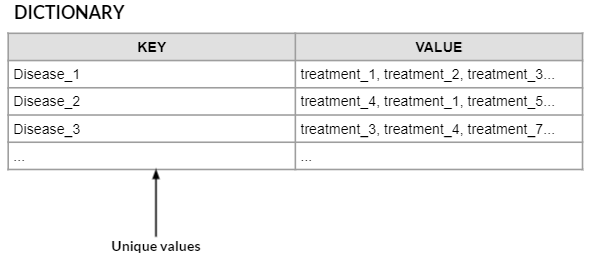

Creating the result dict. which contains the disease to list of Treatment mapping.
- Ignore if the label is 'O' (other)
- Label 'D' indicates a disease, so add the corresponding word to the disease name string
-  Label 'T' indicates a treatment, so add the corresponding word to the treatment name string

In [97]:
result = dict()

for labels, sentence in zip(Y_pred, test_sent):
    disease = ""
    treatment = ""
    label_tokens = zip(labels, sentence.split())

    for label, token in label_tokens:
        if label == 'O':
            continue

        if label == 'D':
            disease += token + " "
        elif label == 'T':
            treatment += token + " "

    disease = disease.strip()
    treatment = treatment.strip()

    if disease and treatment:
      result.setdefault(disease,[]).append(treatment)

result

{'nonimmune hydrops fetalis': ['Trisomy'],
 'hereditary retinoblastoma': ['radiotherapy'],
 'unstable angina or non-Q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['Antichlamydial antibiotics'],
 'primary pulmonary hypertension ( PPH )': ['fenfluramines'],
 'cellulitis': ['G-CSF therapy intravenous antibiotic treatment'],
 'foot infection': ['G-CSF treatment'],
 "early Parkinson 's disease": ['Ropinirole monotherapy'],
 'sore throat': ['Antibiotics'],
 'abdominal tuberculosis': ['steroids'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension': ['intrauterine insemination with donor sperm versus intrauterine insemination'],
 'severe acquired hyperammonemia cancer': ['organ transplantation and chemotherapy'],
 'major pulmonary embolism': ['Thrombolytic treatment right-side hemodynamics'],
 'malignant pleural mesothelioma': ['thoracotomy , radiotherapy , and ch

#### Converting result dictionary to a dataframe


In [98]:
df = pd.DataFrame({"D":result.keys(),"T":result.values()})
df.head(10)

,D,T
0,nonimmune hydrops fetalis,[Trisomy]
1,hereditary retinoblastoma,[radiotherapy]
2,unstable angina or non-Q-wave myocardial infar...,[roxithromycin]
3,coronary-artery disease,[Antichlamydial antibiotics]
4,primary pulmonary hypertension ( PPH ),[fenfluramines]
5,cellulitis,[G-CSF therapy intravenous antibiotic treatment]
6,foot infection,[G-CSF treatment]
7,early Parkinson 's disease,[Ropinirole monotherapy]
8,sore throat,[Antibiotics]
9,abdominal tuberculosis,[steroids]


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [101]:
key = 'hereditary retinoblastoma'
res = df[df['D'] == key]

if not res.empty:
    treatments = res['T'].tolist()[0]
    print(f"Treatments for the disease '{key}' is :", treatments)
else:
    print(f"'{key}' was not found.")

Treatments for the disease 'hereditary retinoblastoma' is : ['radiotherapy']
